# Demo: DHT Distributed ImageNet Training

Este cuaderno demuestra cómo conectar un peer a la red de entrenamiento distribuido usando Hivemind y ResNet50.

In [1]:
import sys
import os
import torch
import hivemind
import matplotlib.pyplot as plt
import numpy as np

# Agregar src al path para importar módulos locales
sys.path.append(os.path.abspath('../src'))

from dhtPeerImagenet import build_model, get_next_log_paths
from datasets import get_webdataset_loader

%matplotlib inline

In [2]:
# Configuración
DATA_DIR = "gs://caso-estudio-2/imagenet-wds" # Ajustar si es necesario
INITIAL_PEER = None # "/ip4/..." si se conoce uno, o None para iniciar uno nuevo/buscar en GCS
HOST_PORT = 31338 # Puerto diferente al default para evitar conflictos si ya corre el script
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {DEVICE}")

Usando dispositivo: cuda


## 1. Carga de Datos (WebDataset)
Intentaremos cargar un batch de datos para visualizarlo.

[TRAIN] Loading WebDataset from: https://storage.googleapis.com/caso-estudio-2/imagenet-wds/train/train-{000000..000009}.tar
🚀 Optimizing for WORKERS=0: Using ThreadedWebDataset for parallel downloads!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].


Batch shape: torch.Size([32, 3, 224, 224])


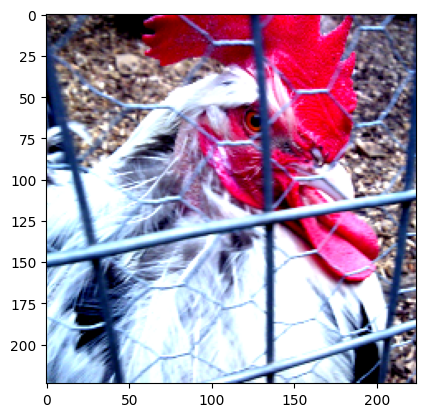

Label: 7


In [3]:
try:
    train_loader = get_webdataset_loader(
        bucket_name=DATA_DIR,
        prefix="",
        batch_size=BATCH_SIZE,
        num_workers=0,
        device=DEVICE,
        is_train=True,
        total_shards=10, # Limitamos shards para demo
        train_prefix="train/train"
    )
    
    # Obtener un batch
    images, labels = next(iter(train_loader))
    print(f"Batch shape: {images.shape}")
    
    # Visualizar algunas imágenes
    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.cpu().numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    # Mostrar primera imagen
    imshow(images[0])
    print(f"Label: {labels[0]}")
    
except Exception as e:
    print(f"Error cargando datos (posiblemente falta acceso GCS o internet): {e}")
    # Crear datos dummy para continuar la demo
    images = torch.randn(BATCH_SIZE, 3, 224, 224).to(DEVICE)
    labels = torch.randint(0, 1000, (BATCH_SIZE,)).to(DEVICE)
    print("Usando datos dummy.")

## 2. Inicialización del Modelo y DHT
Creamos el modelo ResNet50 y nos conectamos al DHT.

In [ ]:
model = build_model(num_classes=1000)
model.to(DEVICE)

# Optimizador base
base_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Configuración DHT
dht = hivemind.DHT(
    host_maddrs=[f"/ip4/0.0.0.0/tcp/{HOST_PORT}"],
    initial_peers=[INITIAL_PEER] if INITIAL_PEER else [],
    start=True
)
print("DHT Conectado!", dht.get_visible_maddrs())

DHT Conectado! [<Multiaddr /ip4/127.0.0.1/tcp/31338/p2p/12D3KooWAgsf3BfPkdKb4LWjvTApk69GWcudoKkbJy4c54BKRwjz>, <Multiaddr /ip4/192.168.1.106/tcp/31338/p2p/12D3KooWAgsf3BfPkdKb4LWjvTApk69GWcudoKkbJy4c54BKRwjz>]


Nov 30 19:39:30.735 [INFO] Found no active peers: None
Nov 30 19:39:33.740 [INFO] Found no active peers: None
Nov 30 19:39:36.743 [INFO] Found no active peers: None
Nov 30 19:39:39.744 [INFO] Found no active peers: None


## 3. Optimizador Distribuido
Configuramos el optimizador de Hivemind para sincronizar gradientes.

In [8]:
opt = hivemind.Optimizer(
    dht=dht,
    run_id="tinyimagenet_resnet50",
    batch_size_per_step=BATCH_SIZE,
    target_batch_size=1000, # Pequeño para demo
    optimizer=base_optimizer,
    use_local_updates=True,
    matchmaking_time=5.0,
    averaging_timeout=10.0,
    verbose=True
)

Nov 30 19:39:41.531 [INFO] Found no active peers: None
Nov 30 19:39:41.593 [INFO] Initializing optimizer manually since it has no tensors in state dict. To override this, provide initialize_optimizer=False
Nov 30 19:39:41.632 [INFO] Sending goodbye to peers...
Nov 30 19:39:41.634 [INFO] No longer fetching tinyimagenet_resnet50_progress
Nov 30 19:39:41.634 [INFO] No longer reporting progress for tinyimagenet_resnet50
Nov 30 19:39:41.636 [INFO] Shutting down averagers...
Nov 30 19:39:41.645 [INFO] Optimizer is shut down


Nov 30 19:39:44.538 [INFO] Found no active peers: None
Nov 30 19:39:47.544 [INFO] Found no active peers: None
Nov 30 19:39:50.550 [INFO] Found no active peers: None


## 4. Paso de Entrenamiento
Simulamos un paso de entrenamiento.

In [10]:
model.train()
opt.zero_grad()

outputs = model(images)
loss = torch.nn.functional.cross_entropy(outputs, labels)
loss.backward()

print(f"Loss antes del paso: {loss.item()}")

# Este paso puede tardar si espera a otros peers
opt.step()

print("Paso de optimizador completado.")

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

Nov 30 19:40:02.571 [INFO] Found no active peers: None
Nov 30 19:40:05.573 [INFO] Found no active peers: None
Nov 30 19:40:08.575 [INFO] Found no active peers: None
